In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install numpy==1.25.0
!pip install gensim

In [ ]:
import numpy as np
print(np.__version__)

1.25.0


In [ ]:
import pandas as pd

import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Loading the dataset

In [ ]:

dataset_path = "/content/drive/MyDrive/7. Racist Sexist or Not Dataset-20250513T133523Z-1-001/7. Racist Sexist or Not Dataset/train_racisit.csv"
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
df.isnull().any()

,0
id,False
label,False
tweet,False


In [ ]:
def text_cleaning_pipeline(dataset, rule = "lemmatize"):
  """
  This...
  """

  data = dataset.lower()

  data = re.sub(r"http\S+|www\S+|https\S+", '',data, flags=re.MULTILINE)

  data = re.sub(r"["
                        u"\U0001F600-\U0001F64F"
                        u"\U0001F300-\U0001F5FF"
                        u"\U0001F680-\U0001F6FF"
                        u"\U0001F1E0-\U0001F1FF"
                        u"\u2702-\u27B0"
                        u"\u24C2-\U0001F251"
                        "]+",
                        r' ', data, flags=re.UNICODE)

  data = re.sub("@[A-Za-z0-9_]+"," ", data)

  data = re.sub("[^0-9A-Za-z ]", "" , data)

  tokens = data.split()

  stop_words = set(stopwords.words('english'))
  result_tokens = []
  for token in tokens:
    if token not in stop_words:
      result_tokens.append(token)
  if rule == "lemmatize":
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in result_tokens]
  elif rule == "stem":
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in result_tokens]
  else:
    print("Pick between lemmatize or stem")


  return " ".join(tokens)


In [ ]:
df['clean_tweet'] = df['tweet'].apply(lambda x: text_cleaning_pipeline(x, rule="lemmatize"))

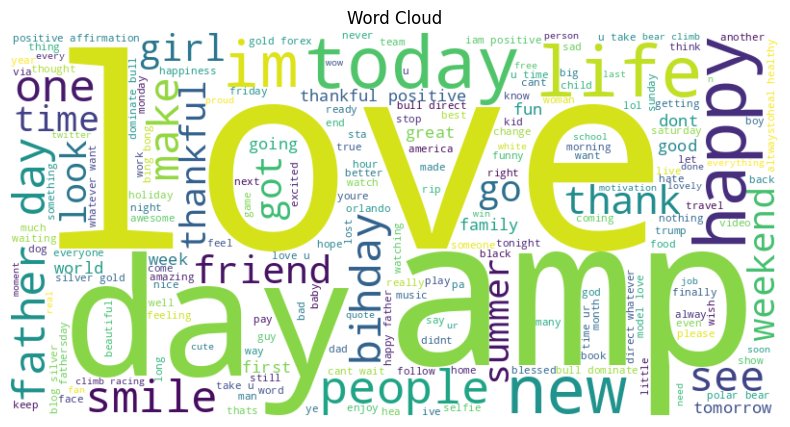

In [ ]:
all_clean_text = " ".join(df['clean_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_clean_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()

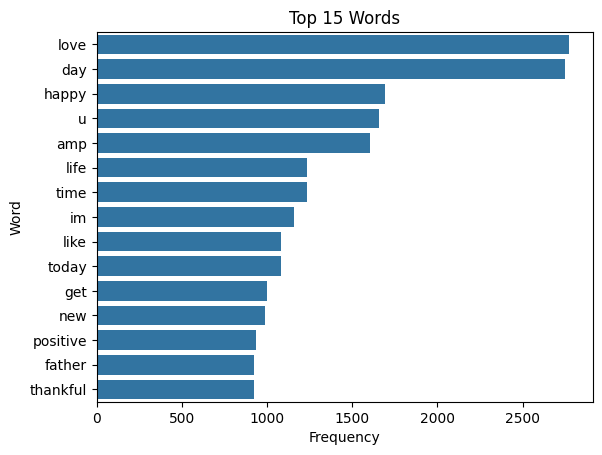

In [ ]:
word_freq = Counter(" ".join(df["clean_tweet"]).split())
common_words = pd.DataFrame(word_freq.most_common(15), columns=['Word', 'Frequency'])
sns.barplot(data=common_words, x='Frequency', y='Word')
plt.title("Top 15 Words")
plt.show()

In [ ]:

X = df['clean_tweet'].values
y = df['label'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size: ",vocab_size)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

max_len = int(np.percentile([len(x) for x in X_train_seq], 95))
print("\nMax Length: ",max_len)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

Vocab size:  33695

Max Length:  13


In [ ]:
def plot_visualization(model_history, model_name):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(model_history.history['loss'], label='Training Loss')
  plt.plot(model_history.history['val_loss'], label='Validation Loss')
  plt.title(f'{model_name}: Training vs Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(model_history.history['accuracy'], label='Training Accuracy')
  plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'{model_name}: Training vs Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

In [ ]:
def evaluate_model(model, model_name):
  loss, accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
  print('Test Loss:', loss)
  print('\nTest Accuracy:', accuracy)
  y_pred = (model.predict(X_val_pad) > 0.5).astype(int)
  print(f"\n\n{model_name} Accuracy: {accuracy_score(y_val, y_pred):.4f}")
  print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
  print("Classification Report:\n", classification_report(y_val, y_pred))

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

In [ ]:
rnn_model1 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])
rnn_model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model1.build(input_shape=(None, max_len))
rnn_model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 13, 64)         │     2,156,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,164,801 (8.26 MB)

 Trainable params: 2,164,801 (8.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rnn_model1_history = rnn_model1.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9288 - loss: 0.2439

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9288 - loss: 0.2437 - val_accuracy: 0.9573 - val_loss: 0.1303
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9826 - loss: 0.0547 - val_accuracy: 0.9543 - val_loss: 0.1369
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9962 - loss: 0.0134 - val_accuracy: 0.9438 - val_loss: 0.1775
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9984 - loss: 0.0071 - val_accuracy: 0.9564 - val_loss: 0.1984
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9988 - loss: 0.0045 - val_accuracy: 0.9489 - val_loss: 0.2098


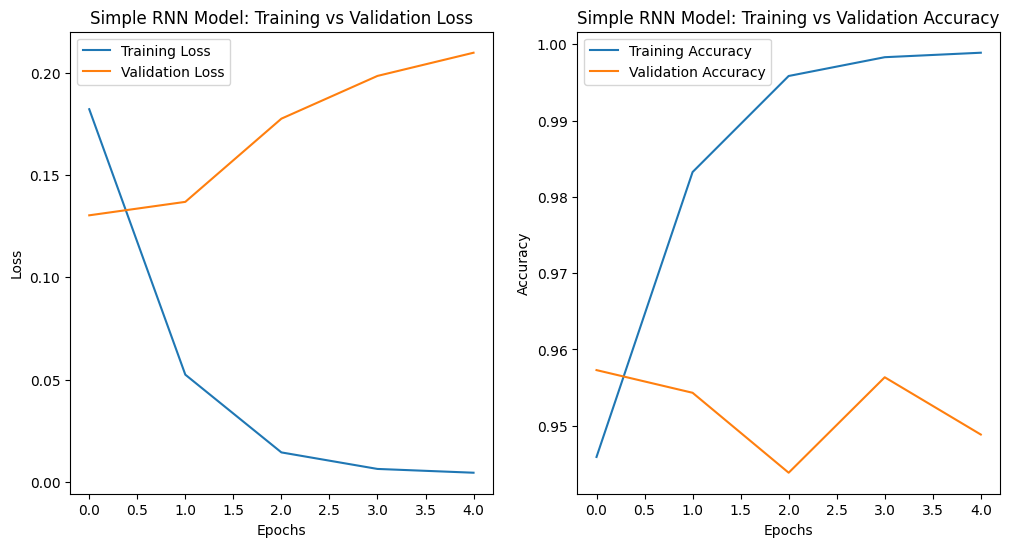

In [ ]:
plot_visualization(rnn_model1_history, "Simple RNN Model")

In [ ]:
evaluate_model(rnn_model1, "Simple RNN Model")

Test Loss: 0.13031914830207825

Test Accuracy: 0.9572970271110535
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Simple RNN Model Accuracy: 0.9573
Confusion Matrix:
 [[5876   61]
 [ 212  244]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.80      0.54      0.64       456

    accuracy                           0.96      6393
   macro avg       0.88      0.76      0.81      6393
weighted avg       0.95      0.96      0.95      6393



In [ ]:
rnn_model1.save('AshrayaPhuyal_Rnn_model1.h5')

### Model 2: LSTM with a trainable Embedding layer

In [ ]:

rnn_model2 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

rnn_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model2.build(input_shape=(None, max_len))
rnn_model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 13, 64)         │     2,156,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,189,569 (8.35 MB)

 Trainable params: 2,189,569 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rnn_model2_history = rnn_model2.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
393/400 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9259 - loss: 0.2674

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9263 - loss: 0.2657 - val_accuracy: 0.9612 - val_loss: 0.1196
Epoch 2/10
398/400 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9806 - loss: 0.0657

400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9806 - loss: 0.0657 - val_accuracy: 0.9603 - val_loss: 0.1193
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9916 - loss: 0.0299 - val_accuracy: 0.9587 - val_loss: 0.1402
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9957 - loss: 0.0146 - val_accuracy: 0.9570 - val_loss: 0.1775
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9972 - loss: 0.0113 - val_accuracy: 0.9521 - val_loss: 0.2119
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9988 - loss: 0.0064 - val_accuracy: 0.9562 - val_loss: 0.2082


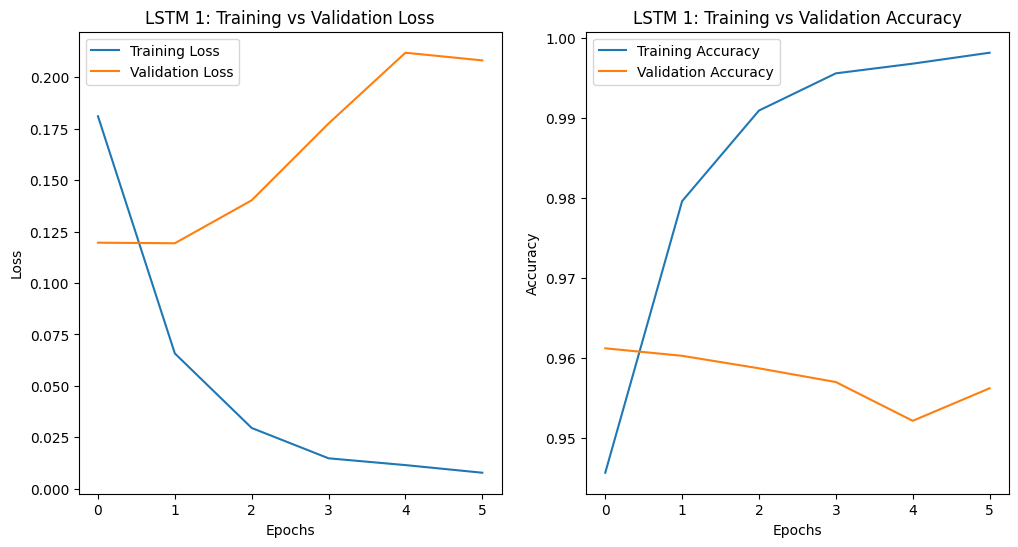

In [ ]:
plot_visualization(rnn_model2_history, "LSTM 1")

In [ ]:
evaluate_model(rnn_model2, "LSTM 1")

Test Loss: 0.11932879686355591

Test Accuracy: 0.960269033908844
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


LSTM 1 Accuracy: 0.9603
Confusion Matrix:
 [[5826  111]
 [ 143  313]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      5937
           1       0.74      0.69      0.71       456

    accuracy                           0.96      6393
   macro avg       0.86      0.83      0.85      6393
weighted avg       0.96      0.96      0.96      6393



In [ ]:
rnn_model2.save('Ashayaphuyal_Rnn_model2.h5')

### Model 3: LSTM with pretrained Word2Vec embeddings

In [ ]:
import gensim.downloader as api

In [ ]:
import numpy as np

In [ ]:
!ls

Ashayaphuyal_2329815_model.h5	best_model.h5  sample_data
AshrayaPhuyal_2329815_model.h5	drive


In [ ]:
embedding_model = api.load('glove-wiki-gigaword-50')
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

In [ ]:
rnn_model3 = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

rnn_model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,684,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,684,750 (6.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,684,750 (6.43 MB)

In [ ]:
rnn_model3_history = rnn_model3.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9302 - loss: 0.2563 - val_accuracy: 0.9417 - val_loss: 0.1675
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9441 - loss: 0.1604 - val_accuracy: 0.9445 - val_loss: 0.1569
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9489 - loss: 0.1393 - val_accuracy: 0.9478 - val_loss: 0.1540
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9528 - loss: 0.1305 - val_accuracy: 0.9504 - val_loss: 0.1458
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9590 - loss: 0.1205 - val_accuracy: 0.9524 - val_loss: 0.1389
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9636 - loss: 0.1074 - val_accuracy: 0.9520 - val_loss: 0.1376
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9658 - loss: 0.1007 - val_accuracy: 0.9535 - val_loss: 0.1415
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9697 - loss: 0.0942 - val_accuracy: 0.

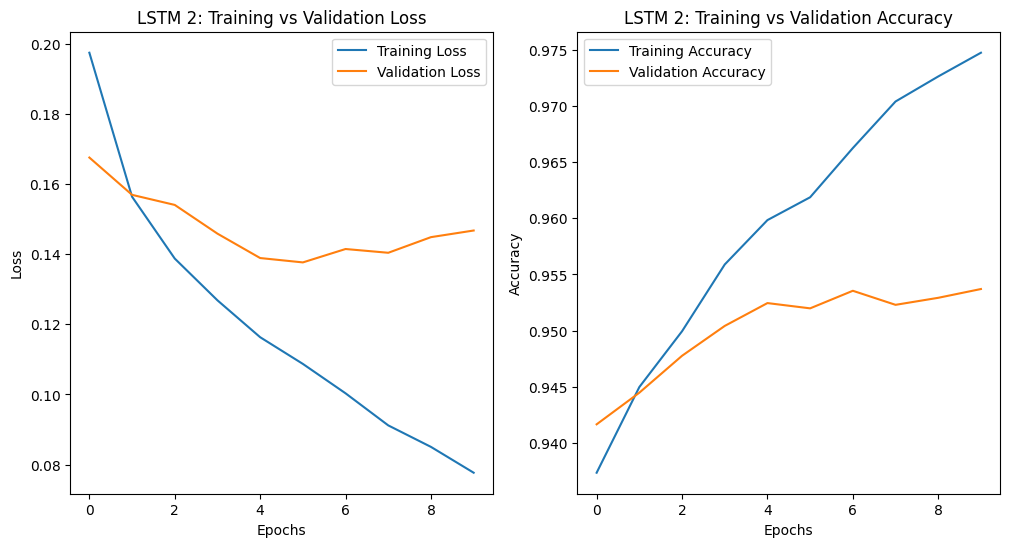

In [ ]:
plot_visualization(rnn_model3_history, "LSTM 2")

In [ ]:
evaluate_model(rnn_model3, "LSTM 2")

Test Loss: 0.13763552904129028

Test Accuracy: 0.9519787430763245
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


LSTM 2 Accuracy: 0.9520
Confusion Matrix:
 [[5851   86]
 [ 221  235]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      5937
           1       0.73      0.52      0.60       456

    accuracy                           0.95      6393
   macro avg       0.85      0.75      0.79      6393
weighted avg       0.95      0.95      0.95      6393



In [ ]:
rnn_model3.save('AshrayaPhuyal_Rnn_model3.h5')

### Predictions

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|\d+", '', text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r"\b(?:{})\b".format('|'.join(stop_words)), '', text)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text.strip()


In [ ]:

def predict_text(model, model_name, text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(pad)[0][0]
    sentiment = 'Racist/Sexist' if pred > 0.5 else 'Not Racist/Sexist'
    print(f"\nPrediction made by model: {model_name}\n")
    print(f"Text: {text}\nPrediction: {sentiment} ({pred:.3f})")

In [ ]:
# Model 1 Prediction
predict_text(rnn_model1, "Simple RNN Model", "i say we because i'm speaking collectively. i've always known. 2016 showed a lot.  andâ¦")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step

Prediction made by model: Simple RNN Model

Text: i say we because i'm speaking collectively. i've always known. 2016 showed a lot.  andâ¦
Prediction: Racist/Sexist (0.621)


In [ ]:
# Model 2 Prediction
predict_text(rnn_model2, "LSTM 1", "it's going to be a great day! the day itself doesn't have a choice in the matter. #feelinggood   #proud #feelingaccomplished #motivated")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

Prediction made by model: LSTM 1

Text: it's going to be a great day! the day itself doesn't have a choice in the matter. #feelinggood   #proud #feelingaccomplished #motivated
Prediction: Not Racist/Sexist (0.002)


In [ ]:
# Model 3 Prediction
predict_text(rnn_model3, "LSTM 2", "happiest place on eah! #disneyworld #orlando #castle   #mickeymouse #likechildrens @user")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Prediction made by model: LSTM 2

Text: happiest place on eah! #disneyworld #orlando #castle   #mickeymouse #likechildrens @user
Prediction: Not Racist/Sexist (0.008)


In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)